In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tifffile as tiff
plt.style.use('ggplot')

In [ ]:
import tensorflow as tf

In [ ]:
images_path = '/content/drive/MyDrive/Data/sandstone_data_for_ML/128_patches/images_as_128x128_patches.tif'
masks_path = '/content/drive/MyDrive/Data/sandstone_data_for_ML/128_patches/masks_as_128x128_patches.tif'

In [ ]:
images = tiff.imread(images_path)
images_array = np.array(images)

masks = tiff.imread(masks_path)
masks_array = np.array(masks)

In [ ]:
print(images_array.shape)
print(masks_array.shape)

(1600, 128, 128)
(1600, 128, 128)


In [ ]:
def show_mask(image, mask, alpha, title='', cmap=None):  
  plt.imshow(image)
  plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
  if title is not None:
    plt.title(title)
  plt.axis('off')

In [ ]:
def show_image(image, title='', cmap = None):
  plt.imshow(image, cmap=cmap, alpha=1)
  if title is not None:
    plt.title(title)
  plt.axis('off')

In [ ]:
np.unique(masks_array[0])

array([1, 2, 3, 4], dtype=uint8)

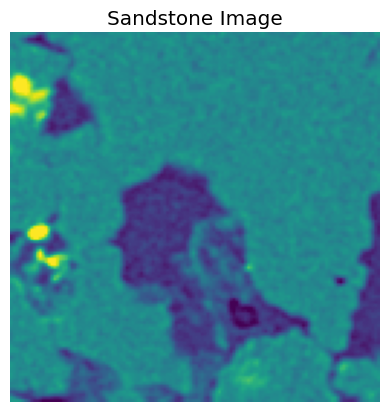

In [ ]:
show_image(images_array[0], title="Sandstone Image")

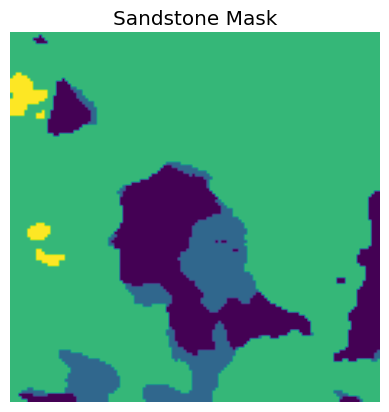

In [ ]:
show_image(masks_array[0], title="Sandstone Mask")

In [ ]:
def display_dataset(images_array, masks_array, alpha, cmap):
  plt.figure(figsize=(10,7))
  for i in tqdm(range(15)):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images_path))
    image = images_array[id]
    mask = masks_array[id]
    show_mask(image, mask, alpha=alpha, cmap=cmap)
  plt.tight_layout()
  plt.suptitle('Dataset', size=16)
  plt.show()

  0%|          | 0/15 [00:00<?, ?it/s]

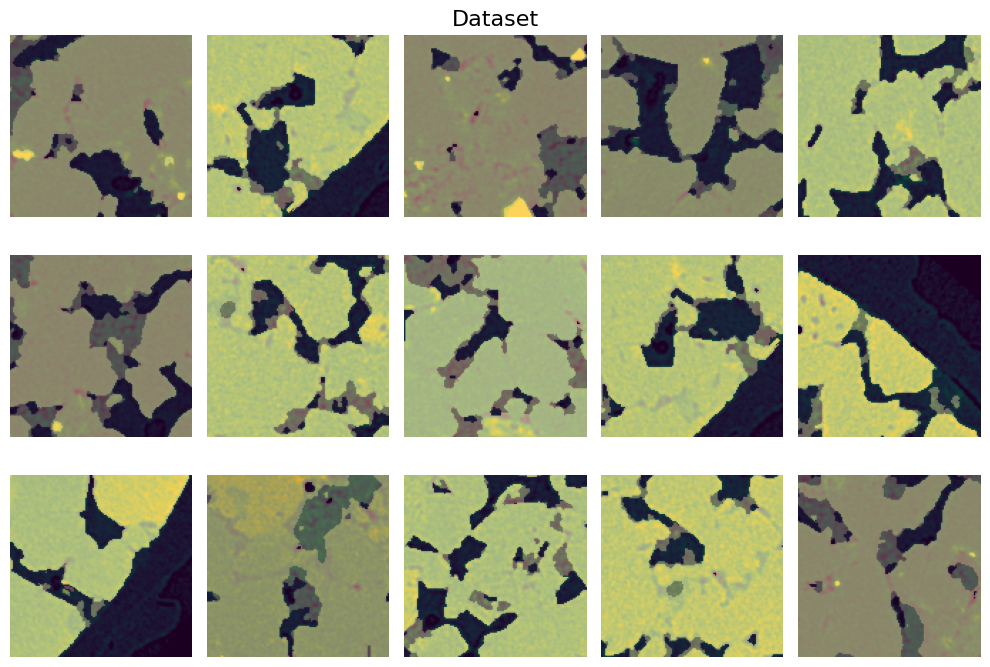

In [ ]:
display_dataset(images_array, masks_array, 0.6, 'copper')

  0%|          | 0/15 [00:00<?, ?it/s]

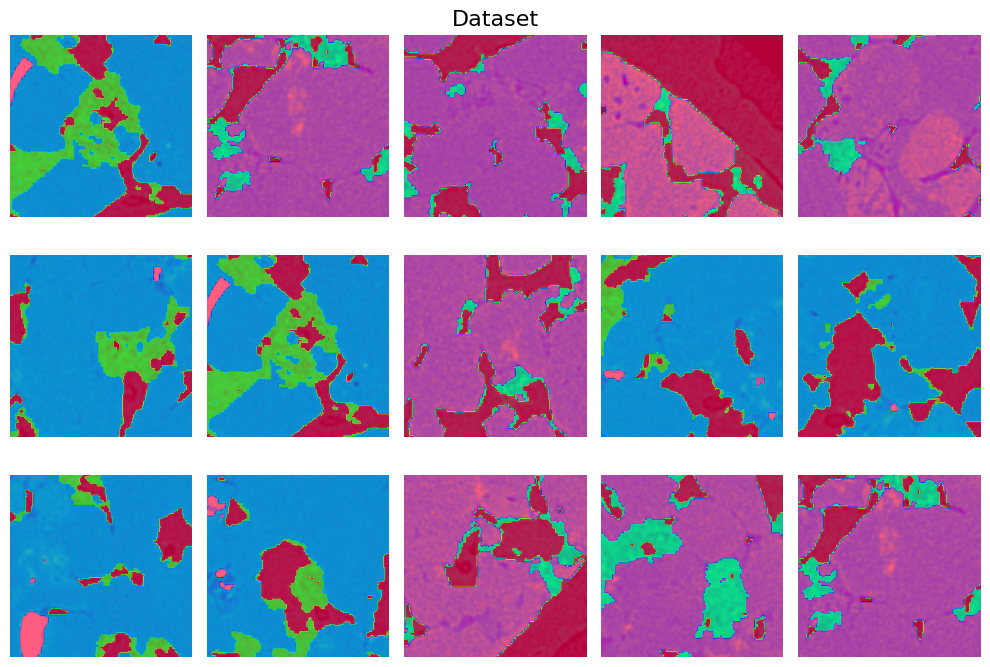

In [ ]:
display_dataset(images_array, masks_array, 0.6, 'gist_rainbow')

  0%|          | 0/15 [00:00<?, ?it/s]

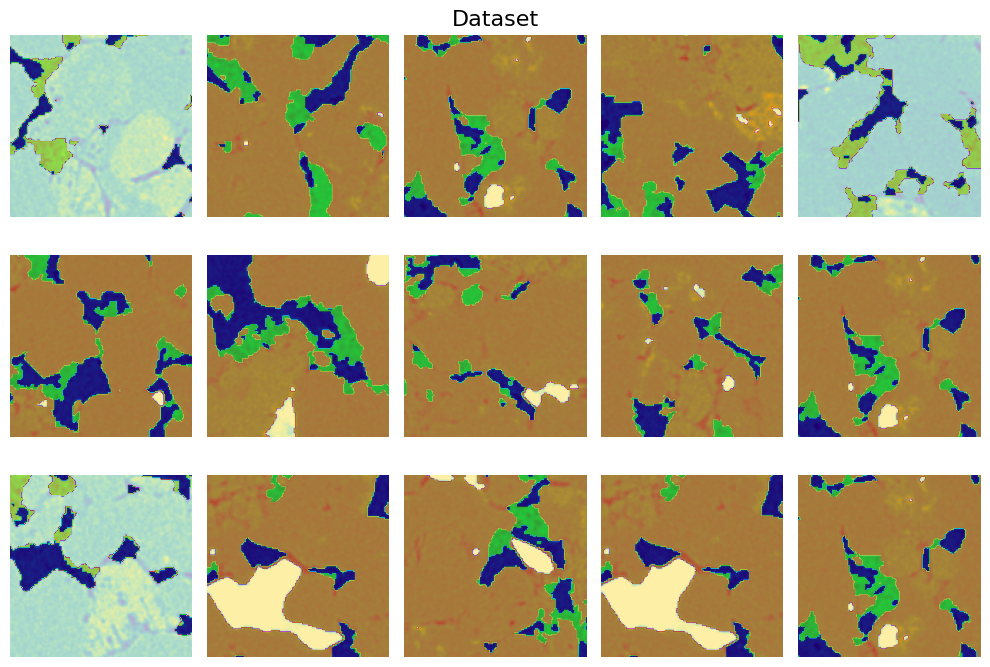

In [ ]:
display_dataset(images_array, masks_array, 0.6, 'gist_ncar')

  0%|          | 0/15 [00:00<?, ?it/s]

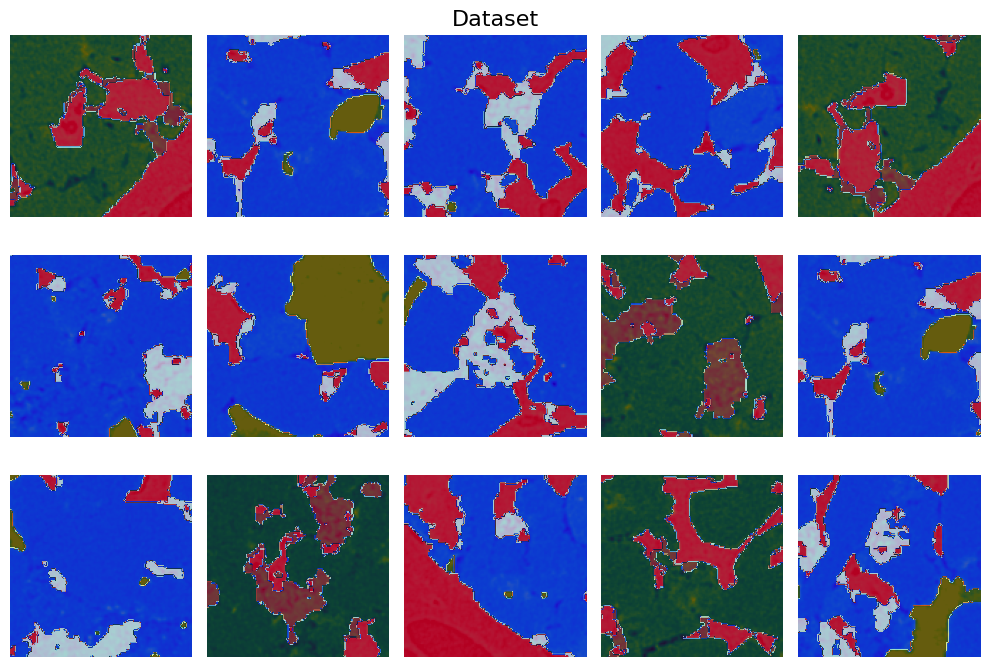

In [ ]:
display_dataset(images_array, masks_array, 0.6, 'flag')

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import normalize
from keras.utils import to_categorical

In [ ]:
def format_masks(masks_array, num_classes):
  labelencoder = LabelEncoder()
  n, h, w = masks_array.shape
  masks_reshaped = masks_array.reshape(-1,1)
  masks_reshaped_encoded = labelencoder.fit_transform(masks_reshaped)
  masks_encoded_original_shape = masks_reshaped_encoded.reshape(n, h, w)
  masks_encoded_original_shape = np.expand_dims(masks_encoded_original_shape, axis=3)
  masks_cat = to_categorical(masks_encoded_original_shape, num_classes=num_classes)
  return masks_cat

In [ ]:
num_classes = 4
masks_array_encoded = format_masks(masks_array, num_classes)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
def display_mod_dataset(images_array, masks_array, alpha, class_num, cmap, title):
  plt.figure(figsize=(10,7))
  for i in tqdm(range(15)):
    plt.subplot(3,5,i+1)
    image = images_array[i]
    mask = masks_array[i][:,:,class_num]
    show_mask(image, mask, alpha=alpha, cmap=cmap)
  plt.tight_layout()
  plt.suptitle(title, size=16)
  plt.show()

In [ ]:
masks_array_encoded[:15].shape

(15, 128, 128, 4)

  0%|          | 0/15 [00:00<?, ?it/s]

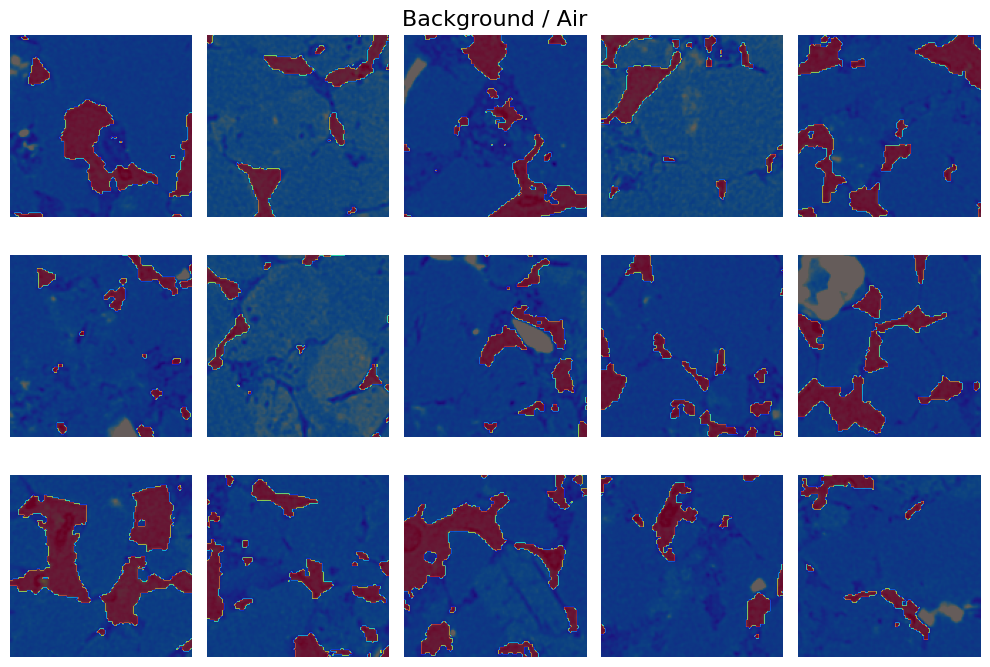

In [ ]:
display_mod_dataset(images_array[:15], masks_array_encoded[:15], 0.6, 0, 'jet', 'Background / Air')

  0%|          | 0/15 [00:00<?, ?it/s]

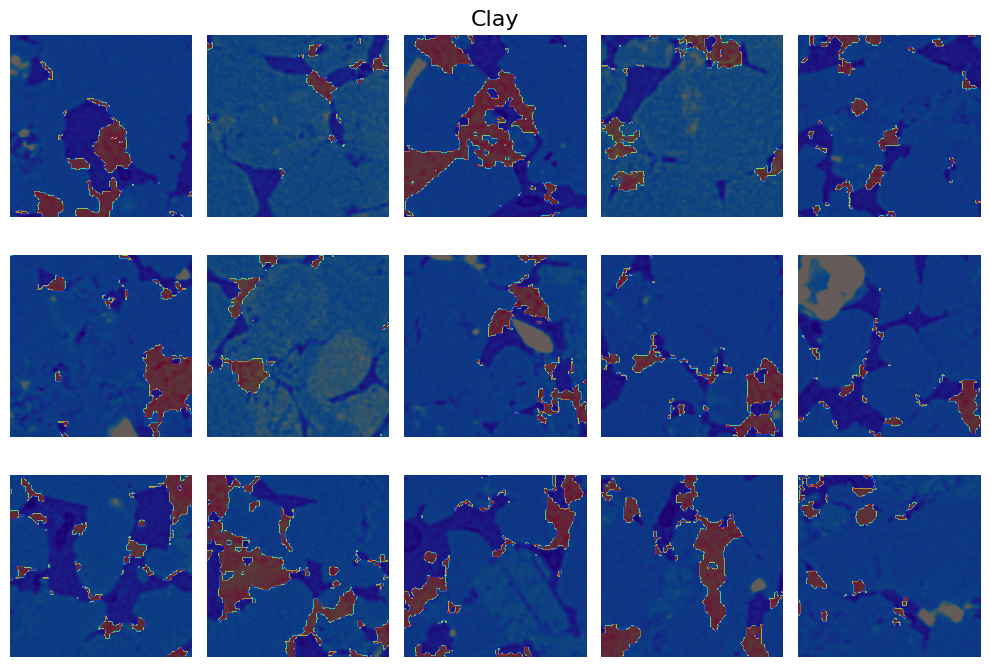

In [ ]:
display_mod_dataset(images_array[:15], masks_array_encoded[:15], 0.6, 1, 'jet', 'Clay')

  0%|          | 0/15 [00:00<?, ?it/s]

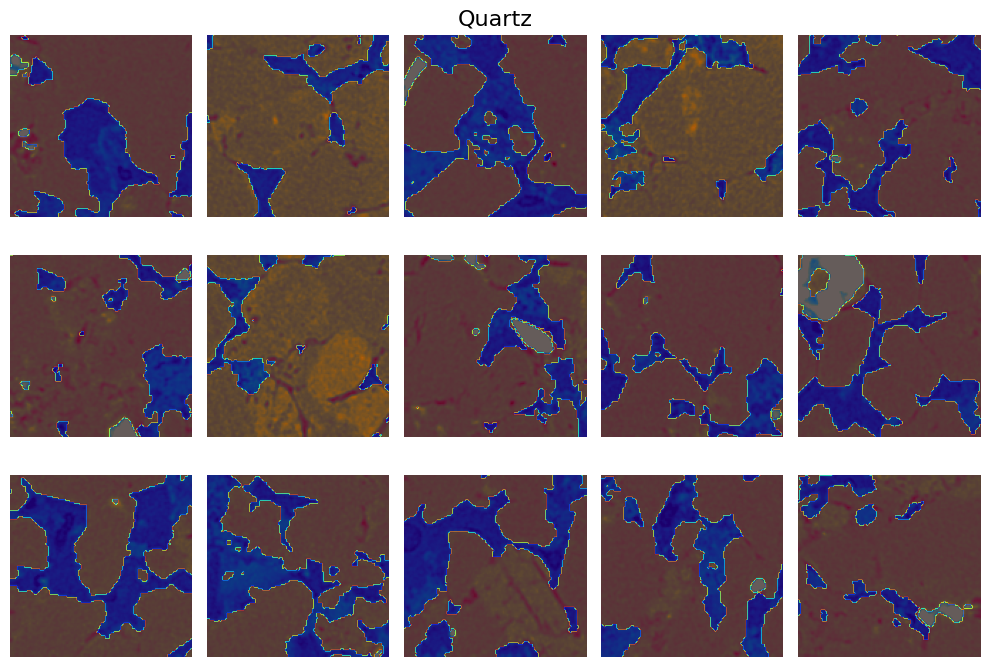

In [ ]:
display_mod_dataset(images_array[:15], masks_array_encoded[:15], 0.6, 2, 'jet', 'Quartz')

  0%|          | 0/15 [00:00<?, ?it/s]

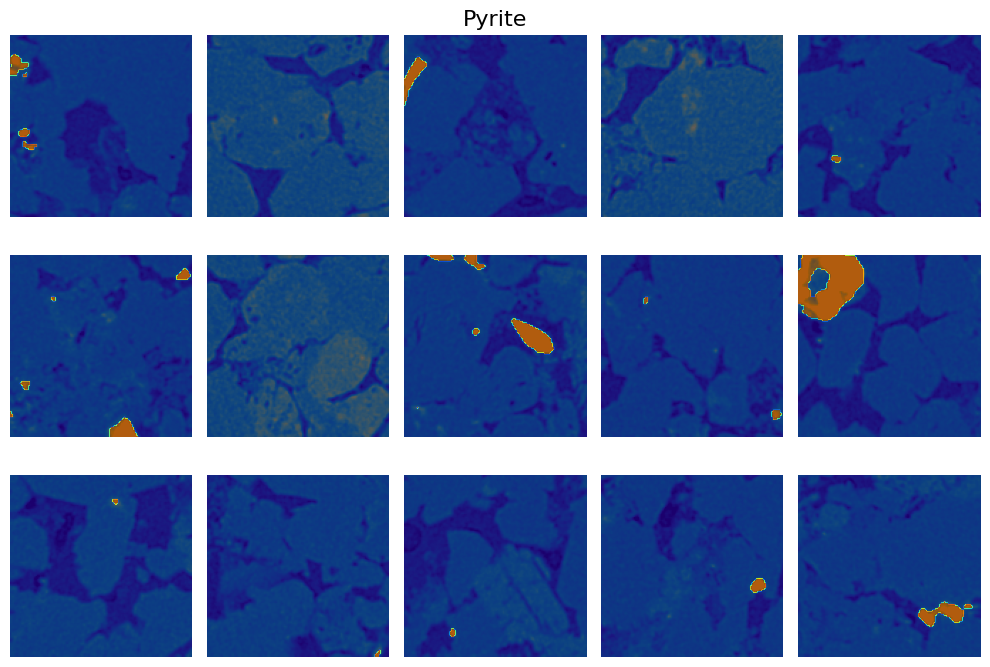

In [ ]:
display_mod_dataset(images_array[:15], masks_array_encoded[:15], 0.6, 3, 'jet', 'Pyrite')

In [ ]:
images_array = np.expand_dims(images_array, axis=3)
images_array_normalize = normalize(images_array, axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_vali, y_train, y_vali = train_test_split(images_array_normalize, masks_array_encoded, test_size=0.2)

In [ ]:
!pip -q install tf-explain

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dropout, Input, MaxPool2D, BatchNormalization, UpSampling2D, concatenate, Add, Multiply
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import MeanIoU
from tf_explain.core.grad_cam import GradCAM
from tensorflow.keras.utils import plot_model

In [ ]:
class EncoderBlock(Layer):
  def __init__(self, filters, rate, pooling=True, **kwargs):
    super(EncoderBlock, self).__init__(**kwargs)

    self.filters = filters
    self.rate = rate
    self.pooling = pooling

    self.cnn1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
    self.dropout = Dropout(rate)
    self.cnn2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
    self.pool = MaxPool2D()

  def call(self, X):
      x = self.cnn1(X)
      x = self.dropout(x)
      x = self.cnn2(x)
      if self.pooling:
          y = self.pool(x)
          return y, x
      else:
          return x

  def get_config(self):
      base_config = super().get_config()
      return {
          **base_config,
          "filters":self.filters,
          'rate':self.rate,
          'pooling':self.pooling
      }

In [ ]:
class DecoderBlock(Layer):
  def __init__(self, filters, rate, **kwargs):
    super(DecoderBlock, self).__init__(**kwargs)

    self.filters = filters
    self.rate = rate

    self.upsampling2d = UpSampling2D()
    self.encodeblock = EncoderBlock(filters, rate, pooling=False)

  def call(self, X):
    X, skip_X = X
    x = self.upsampling2d(X)
    c_ = concatenate([x, skip_X])
    x = self.encodeblock(c_)
    return x

  def get_config(self):
    base_config = super().get_config()
    return {
        **base_config,
        "filters":self.filters,
        'rate':self.rate,
    }

In [ ]:
class AttentionGate(Layer):
  def __init__(self, filters, bn, **kwargs):
    super(AttentionGate, self).__init__(**kwargs)

    self.filters = filters
    self.bn = bn

    self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
    self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
    self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
    self.resample = UpSampling2D()
    self.BN = BatchNormalization()

  def call(self, X):
    X, skip_X = X

    x = self.normal(X)
    skip = self.down(skip_X)
    x = Add()([x, skip])
    x = self.learn(x)
    x = self.resample(x)
    f = Multiply()([x, skip_X])
    if self.bn:
      return self.BN(f)
    else:
      return f

  def get_config(self):
    base_config = super().get_config()
    return {
        **base_config,
        "filters":self.filters,
        "bn":self.bn
    }

In [ ]:
input_layer = Input(shape=images_array_normalize.shape[-3:])

In [ ]:
p1, c1 = EncoderBlock(32,0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64,0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128,0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256,0.2, name="Encoder4")(p3)

In [ ]:
encoding = EncoderBlock(512,0.3, pooling=False, name="Encoding")(p4)

In [ ]:
a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256,0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, a3])


a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

In [ ]:
output_layer = Conv2D(num_classes, kernel_size=1, activation='softmax', padding='same')(d4)

In [ ]:
model = Model(
    inputs=[input_layer],
    outputs=[output_layer]
)

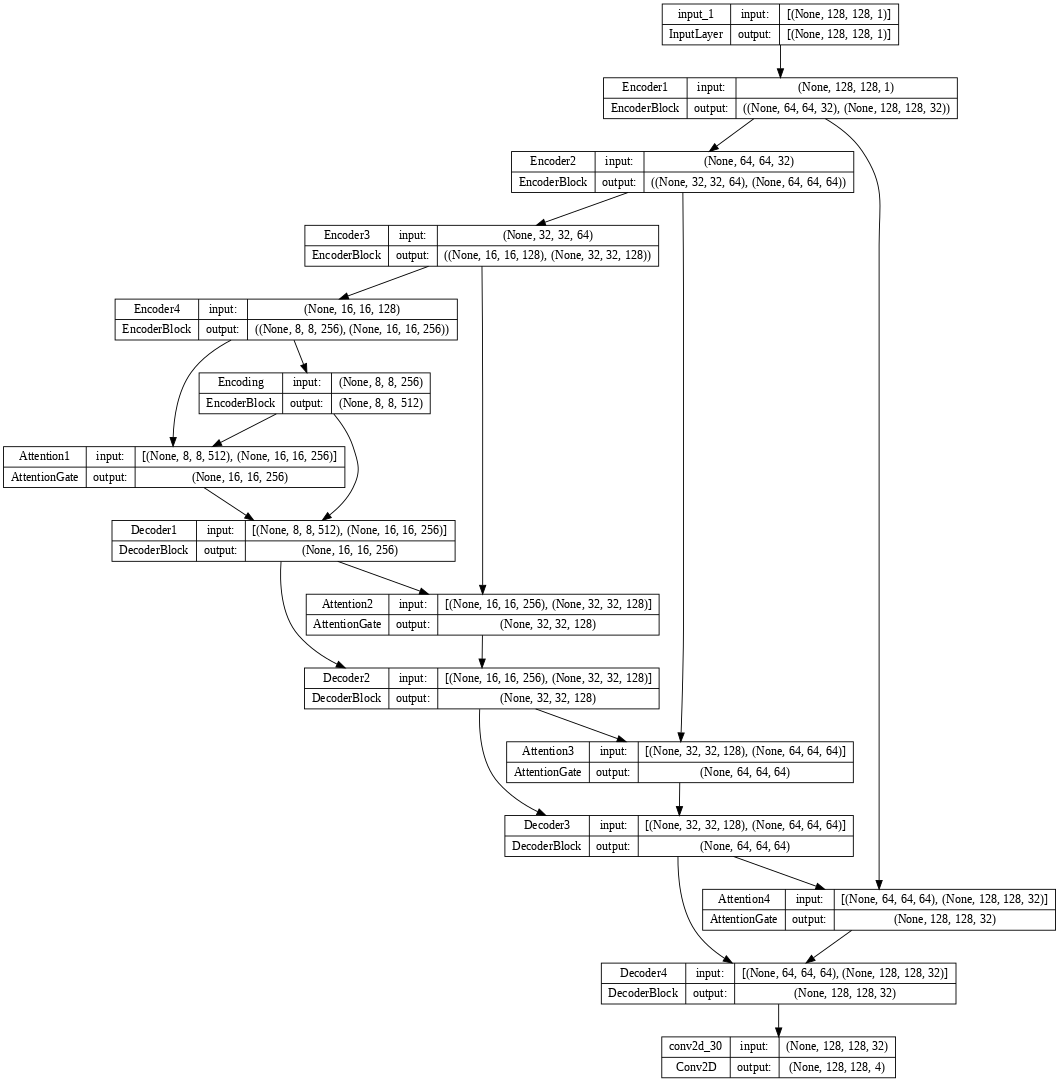

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, dpi=64)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 Encoder1 (EncoderBlock)        ((None, 64, 64, 32)  9568        ['input_1[0][0]']                
                                , (None, 128, 128,                                                
                                32))                                                              
                                                                                                  
 Encoder2 (EncoderBlock)        ((None, 32, 32, 64)  55424       ['Encoder1[0][0]']           

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy', MeanIoU(num_classes=4, name='IoU')]
)

In [ ]:
BATCH_SIZE = 4
SPE = len(images_array_normalize)//BATCH_SIZE

In [ ]:
cb = [
    ModelCheckpoint("model.h5", save_best_only=True)
]

In [ ]:
results = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=BATCH_SIZE,
    callbacks=cb
)

Epoch 1/150
256/256 [==============================] - 27s 57ms/step - loss: 0.0383 - accuracy: 0.9844 - IoU: 0.5326 - val_loss: 0.1582 - val_accuracy: 0.9628 - val_IoU: 0.6317
Epoch 2/150
256/256 [==============================] - 13s 50ms/step - loss: 0.0378 - accuracy: 0.9846 - IoU: 0.5453 - val_loss: 0.1081 - val_accuracy: 0.9680 - val_IoU: 0.5227
Epoch 3/150
256/256 [==============================] - 12s 46ms/step - loss: 0.0374 - accuracy: 0.9847 - IoU: 0.5497 - val_loss: 0.1791 - val_accuracy: 0.9612 - val_IoU: 0.6775
Epoch 4/150
256/256 [==============================] - 12s 48ms/step - loss: 0.0381 - accuracy: 0.9847 - IoU: 0.5566 - val_loss: 0.1266 - val_accuracy: 0.9667 - val_IoU: 0.5849
Epoch 5/150
256/256 [==============================] - 12s 46ms/step - loss: 0.0375 - accuracy: 0.9846 - IoU: 0.5457 - val_loss: 0.2094 - val_accuracy: 0.9574 - val_IoU: 0.6992
Epoch 6/150
256/256 [==============================] - 12s 46ms/step - loss: 0.0372 - accuracy: 0.9847 - IoU: 0.553

In [ ]:
loss, accuracy, iou, val_loss, val_accuracy, val_iou = results.history.values()

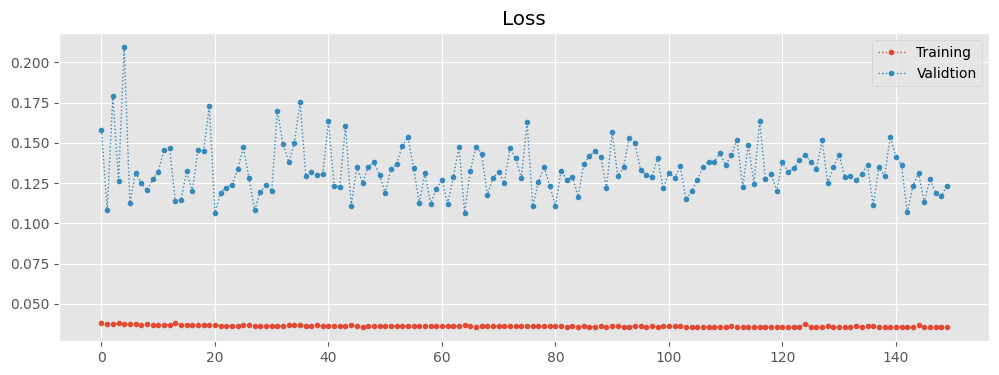

In [ ]:
plt.figure(figsize=(12,4))
plt.title("Loss")
plt.plot(loss, ".:", label="Training", linewidth=1)
plt.plot(val_loss, ".:", label="Validtion", linewidth=1)
plt.legend()
plt.show()

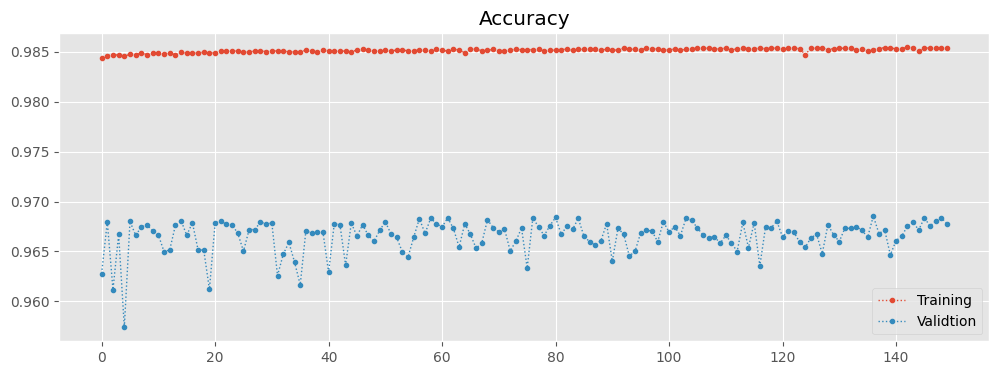

In [ ]:
plt.figure(figsize=(12,4))
plt.title("Accuracy")
plt.plot(accuracy, ".:", label="Training", linewidth=1)
plt.plot(val_accuracy, ".:", label="Validtion", linewidth=1)
plt.legend()
plt.show()

In [ ]:
loss, acc, iou = model.evaluate(X_vali, y_vali)
print("Accuracy is = ", (np.round(acc,2) * 100.0), "%")

10/10 [==============================] - 1s 70ms/step - loss: 0.1106 - accuracy: 0.9691 - IoU: 0.6065
Accuracy is =  97.0 %


1/1 [==============================] - 0s 32ms/step


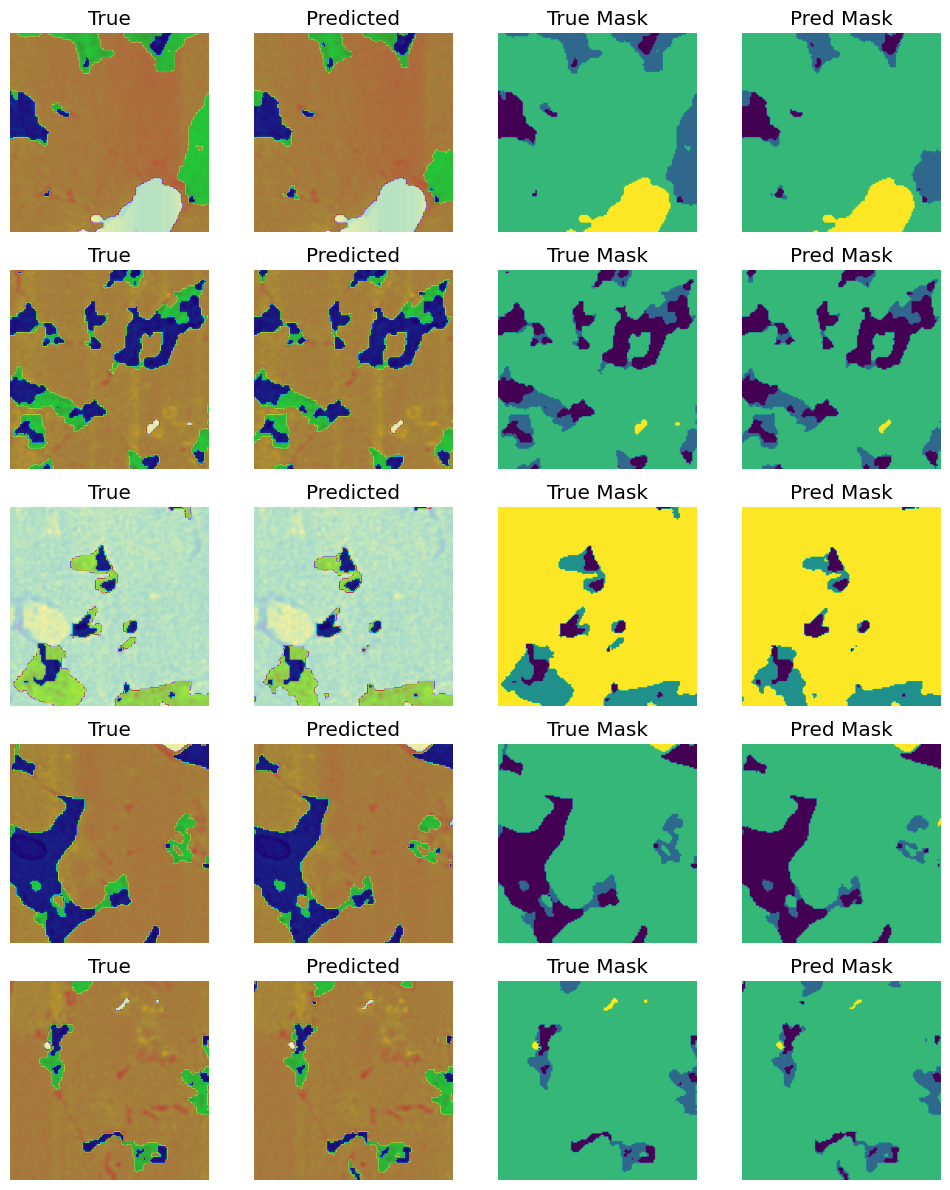

In [ ]:
plt.figure(figsize=(10,12))
n=0
for i in range(1,(5*4)+1):
  plt.subplot(5,4,i)
  if n==0:
    id = np.random.randint(len(X_vali))
    test_img = X_vali[id]
    test_mask = y_vali[id]

    test_img_norm=test_img[:,:,0][:,:,None]
    test_img_input=np.expand_dims(test_img_norm, 0)
    prediction = (model.predict(test_img_input))
    pred_mask=np.argmax(prediction, axis=3)[0,:,:]

    test_mask=np.argmax(test_mask, axis=2)
    
    show_mask(test_img, test_mask, alpha=0.6,title='True', cmap='gist_ncar')
    n+=1
  elif n==1:
    show_mask(test_img, pred_mask, alpha=0.6, title='Predicted', cmap='gist_ncar')
    n+=1

  elif n==2:
    show_image(test_mask, title='True Mask')
    n+=1
  elif n==3:
    #pred_mask = (pred_mask>0.5).astype('float')
    #show_mask(test_img, pred_mask, alpha=0.6, title='Processed Mask')
    show_image(pred_mask, title='Pred Mask')
    n=0
plt.tight_layout()
plt.show()